<a href="https://colab.research.google.com/github/HakanBayazitHabes/LSTM-Tesla/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM(Long Short-Term Memory) ile Hisse Senedi Fiyatı Tahminlemesi

1) İş Problemi (Business Problem)

2) Veriyi Anlamak (Data Understanding)

3) Veriyi Hazırlamak (Data Preparation)

4) Modelleme (Modeling)

5) Değerlendirme (Evuluation)

## 1) İş Problemi (Business Problem)



*   **Date:** İlgili işlem gününün tarihini temsil etmektedir.
*   **Open:** İlgili işlem gününe ait hisse başlangıç fiyatını temsil etmektedir.
*   **High:** İlgili işlem gününe ait en yüksek fiyatı temsil etmektedir.
*   **Low:** İlgili işlem günüe ait en düşük fiyatı temsil etmektedir.
*   **Close:**  İlgili işlem gününe ait en düşük fiyatı temsil etmektedir.
*   **Adj Close:** İlgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatını temsil etmektedir.
*   **Volume:** İlgili işlem gününe ait işlem hacmi bilgisini temsil etmektedir.



## 2) Veriyi Anlamak (Data Understanding)

In [204]:
#Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Warning kapatmak için kullanılmkatadır
import warnings
warnings.filterwarnings('ignore')

# Tensorflow warning engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [205]:
df = pd.read_csv("/content/drive/MyDrive/Turkcell/TSLA.csv")

In [206]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [207]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape) # Değişkenlerin boyut bilgisi
    print("##################### Types #####################")
    print(dataframe.dtypes) # Değişkenlerin tip bilgisini
    print("##################### Head #####################")
    print(dataframe.head(head)) # Değişkenlerin ilk 5 değeri
    print("##################### Tail #####################")
    print(dataframe.tail(head)) # Değişkenlerin son 5 değeri
    print("##################### NA #####################")
    print(dataframe.isnull().sum())  # Değişkenlerin boş değer bilgisi
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [208]:
check_df(df)

##################### Shape #####################
(2416, 7)
##################### Types #####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
##################### Head #####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
##################### Tail #####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575

In [209]:
df["Date"] = pd.to_datetime(df["Date"])

In [210]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [211]:
tesla_df = df[["Date","Close"]]

In [212]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [213]:
print("Minimum Tarih:", tesla_df["Date"].min())
print("Maximum Tarih:", tesla_df["Date"].max())

Minimum Tarih: 2010-06-29 00:00:00
Maximum Tarih: 2020-02-03 00:00:00


In [214]:
tesla_df.index = tesla_df["Date"]

In [215]:
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [216]:
tesla_df.drop("Date", axis=1, inplace=True)

In [217]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [218]:
result_df = tesla_df.copy()

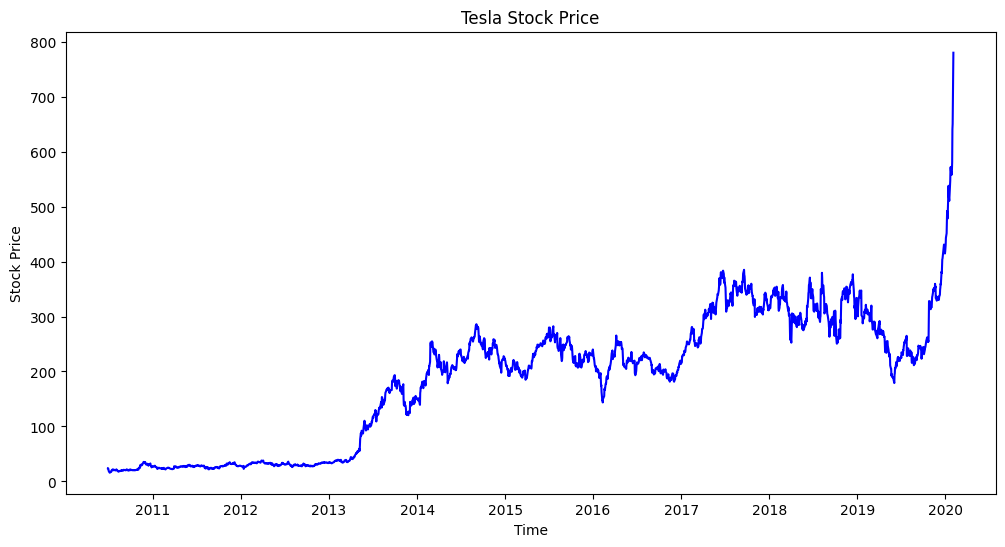

In [219]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_df['Close'], color='blue')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.show()

In [220]:
tesla_df = tesla_df.values

In [221]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [222]:
tesla_df = tesla_df.astype('float32')

## 3) Veriyi Hazırlamak (Data Preparation)

In [223]:
# train-test ayrımının yapılması

def split_data(dataframe, test_size):
  pos = int(round(len(dataframe) * (1 - test_size)))
  train = dataframe[:pos]
  test = dataframe[pos:]
  return train, test, pos

In [224]:
train, test, pos = split_data(tesla_df, 0.20)

In [225]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [226]:
scaler_train = MinMaxScaler(feature_range=(0, 1))

In [227]:
train = scaler_train.fit_transform(train)

In [228]:
scaler_test = MinMaxScaler(feature_range=(0, 1))

In [229]:
test = scaler_test.fit_transform(test)

In [230]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [231]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [232]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i, 0])
    Y.append(data[i, 0])
  return np.array(X), np.array(Y)

In [233]:
lookback = 20

In [234]:
# Train Veri Seti
X_train, y_train = create_features(train, lookback)

# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [235]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [236]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [237]:
y_train[0:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

In [239]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


## 4) Modelleme (Modeling)

In [242]:
model = Sequential()
model.add(LSTM(50, activation='relu' , input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [243]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                14200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [244]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması
model.compile(loss='mean_squared_error', optimizer='adam')

In [245]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"),
             ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, save_weights_only=False , verbose=1, mode="min")]

In [246]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/100
85/96 [=========================>....] - ETA: 0s - loss: 0.0083
Epoch 1: val_loss improved from inf to 0.00443, saving model to best_model.h5
96/96 [==============================] - 4s 10ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 2/100
85/96 [=========================>....] - ETA: 0s - loss: 0.0054
Epoch 2: val_loss improved from 0.00443 to 0.00425, saving model to best_model.h5
96/96 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 3/100
94/96 [============================>.] - ETA: 0s - loss: 0.0058
Epoch 3: val_loss improved from 0.00425 to 0.00397, saving model to best_model.h5
96/96 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 4/100
82/96 [========================>.....] - ETA: 0s - loss: 0.0042
Epoch 4: val_loss did not improve from 0.00397
96/96 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 5/100
84/96 [=========================>....] - ETA: 

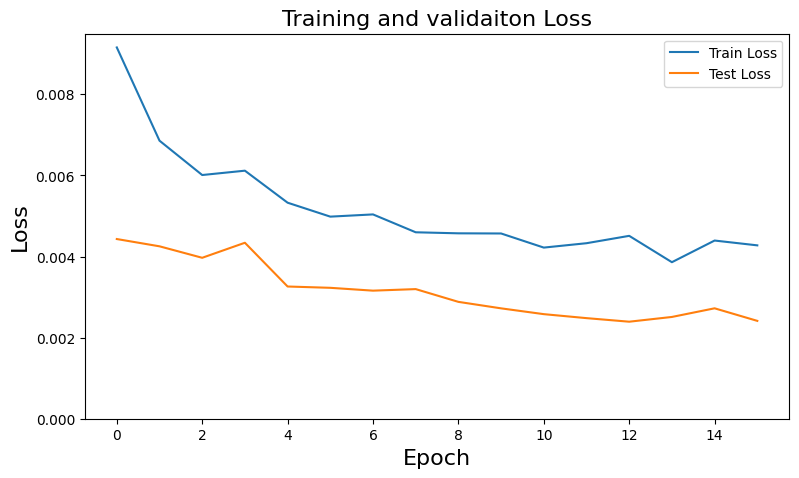

In [247]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and validaiton Loss', fontsize=16)
plt.show()

## 5) Değelerlendirme (Evaluation)

In [249]:
loss = model.evaluate(X_test, y_test, batch_size=20)
print("\nTest loss: %.1f%%" % (100.0 * loss))

24/24 [==============================] - 0s 4ms/step - loss: 0.0024

Test loss: 0.2%


In [250]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [251]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_train.inverse_transform(test_predict)

In [252]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_train.inverse_transform(y_test)

In [253]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [254]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [255]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 13.086304664611816
Test RMSE: 18.13711929321289


In [257]:
train_prediction_df = result_df[lookback:pos]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,36.596729
2010-07-29,20.350000,36.596729
2010-07-30,19.940001,36.596729
2010-08-02,20.920000,36.596729
2010-08-03,21.950001,36.596729


In [259]:
test_prediction_df = result_df[pos+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,101.227325
2018-04-04,286.940002,99.289062
2018-04-05,305.720001,98.571350
2018-04-06,299.299988,98.458572
2018-04-09,289.660004,98.780090


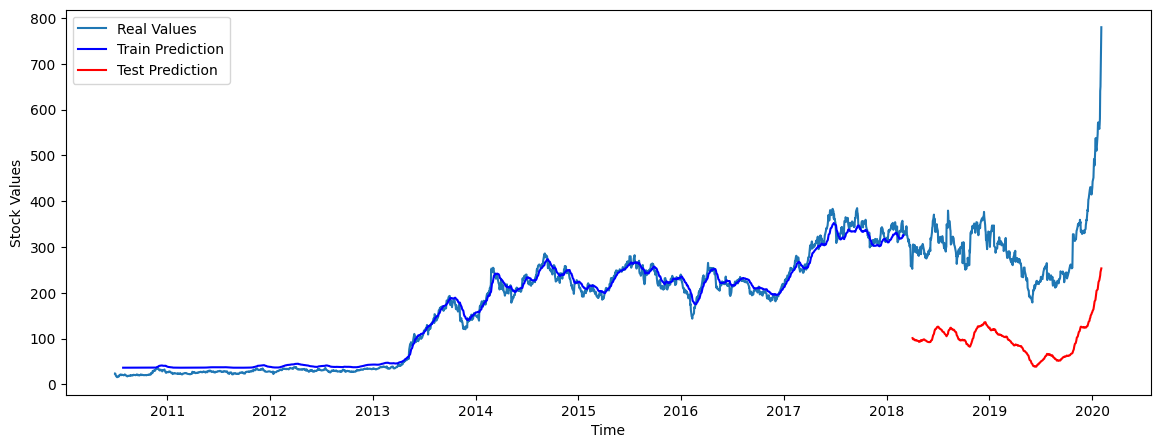

In [260]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14, 5))
plt.plot(result_df, label = 'Real Values')
plt.plot(train_prediction_df["Predicted"], color = 'blue', label = 'Train Prediction')
plt.plot(test_prediction_df["Predicted"], color = 'red', label = 'Test Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()